# Notebook 3: Modelado Predictivo SARIMAX con Variables Exógenas
**Proyecto:** Análisis SARIMAX - Starbucks Corporation (SBUX)  
**Investigador:** Frankli Zeña Zeña (UNI)
___   

En este notebook construiremos el modelo SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables). 
Utilizaremos nuestro dataset maestro que combina:
1. **Componente Endógeno:** La serie de tiempo histórica de Starbucks (Volumen / Precio).
2. **Componentes Exógenos Cuantitativos:** Estados financieros (`Revenue`, `Margen_Operativo_%`).
3. **Componentes Exógenos Cualitativos:** Variables Dummy de intervención (Shocks, Earnings, Cambios de CEO, etc.).

## Paso 1: Carga de Datos y Definición de Variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Para evitar avisos molestos de deprecación

``1. Cargamos el dataset maestro``

In [2]:
ruta_archivo = '../data/transformed/sbux_master_sarimax.csv'
df = pd.read_csv(ruta_archivo, index_col='Fecha', parse_dates=True)
df = df.dropna() # Por siacaso
df

,Date,Adj Close,Volume,Vol_Avg_20,Vol_Anomaly,Log_Return,Margen_Operativo_%,Revenue,choque_estructural,shock_extremo,earnings,riesgo_pais,shock_costos
Fecha,,,,,,,,,,,,,
2021-03-31,2021-03-31,97.421112,6478400,7244615.0,False,-0.009110,14.811039,6668.0,0,0,0,0,0
2021-04-01,2021-04-01,97.519173,5793000,7173675.0,False,0.001006,14.811039,6668.0,0,0,0,0,0
2021-04-05,2021-04-05,98.981331,6913100,7241335.0,False,0.014882,14.811039,6668.0,0,0,0,0,0
2021-04-06,2021-04-06,100.880363,6745200,7322620.0,False,0.019004,14.811039,6668.0,0,0,0,0,0
2021-04-07,2021-04-07,100.916023,5629600,7328555.0,False,0.000353,14.811039,6668.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-09,2026-02-09,98.345779,7150600,11434955.0,False,-0.004737,8.984274,9915.1,1,0,0,0,0
2026-02-10,2026-02-10,96.905067,8543500,11497655.0,False,-0.014758,8.984274,9915.1,1,0,0,0,0
2026-02-11,2026-02-11,98.484879,6949100,11567015.0,False,0.016171,8.984274,9915.1,1,0,0,0,0


``2. Definimos nuestras variables ...``

In [32]:
target_col = 'Adj Close'

# Variables a predecir (Endógena - 'y').
y = df[target_col] 

# Variables predictoras (Exógenas - 'X')
exog_cols = [
    'Margen_Operativo_%', 'Revenue', 
    'choque_estructural', 'shock_extremo', 
    'earnings', 'riesgo_pais', 'shock_costos'
]
X = df[exog_cols]

print(f"Dataset cargado. Dimensión de y: {y.shape}, Dimensión de X: {X.shape}")

Dataset cargado. Dimensión de y: (1225,), Dimensión de X: (1225, 7)


## Paso 2: División de la Muestra (Train / Test Split)

Para garantizar la validez predictiva de nuestro modelo SARIMAX y evitar la "fuga de datos", dividiremos la serie cronológicamente. 
* **Train (Entrenamiento):** Usaremos el 80% o 85% de los datos históricos más antiguos para que el modelo aprenda los patrones, tendencia, estacionalidad y el peso de nuestras variables exógenas (financieras y dummies).
* **Test (Prueba):** Reservaremos el 15% o 20% final (los datos más recientes) para evaluar qué tan bien el modelo predice datos que "nunca ha visto".

Todas las pruebas estadísticas a partir de ahora se harán **exclusivamente sobre el conjunto Train**.

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [34]:
# Calculamos el índice de corte
split_idx = int(len(df) * 0.8)

# Dividimos cronológicamente
df_train = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]

print(f"Muestra total: {len(df)} días")
print(f"Conjunto de Entrenamiento (Train): {len(df_train)} días (hasta {df_train.index[-1].date()})")
print(f"Conjunto de Prueba (Test): {len(df_test)} días (desde {df_test.index[0].date()})")

Muestra total: 1225 días
Conjunto de Entrenamiento (Train): 980 días (hasta 2025-02-24)
Conjunto de Prueba (Test): 245 días (desde 2025-02-25)


In [35]:
# Crear gráfico interactivo
fig = go.Figure()

# Agregar datos de entrenamiento
fig.add_trace(go.Scatter(x=df_train.index, y=df_train[target_col], mode='lines', name='Data de Entrenamiento', line=dict(color='blue')))
# Agregar datos de prueba
fig.add_trace(go.Scatter(x=df_test.index, y=df_test[target_col], mode='lines', name='Data de Validación', line=dict(color='orange')))
# Personalizar el diseño
fig.update_layout(
    title=f'Descomposición Clásica Interactiva: {target_col} (SBUX)',
    xaxis_title='Fecha',
    yaxis_title=target_col,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

## Paso 3: Descomposición Clásica de la Serie de Tiempo

Antes de aplicar pruebas matemáticas ciegas, debemos inspeccionar visualmente los componentes de la serie en el conjunto Train. Usaremos una descomposición aditiva matemática:
$$Y_t = T_t + S_t + R_t$$
Donde $Y_t$ es el valor observado, $T_t$ la tendencia, $S_t$ la estacionalidad y $R_t$ los residuos.

*Nota:* Como estamos usando datos bursátiles diarios (aprox. 252 días hábiles al año y 21 al mes), ajustaremos el `period` de la estacionalidad a 21 para observar ciclos mensuales, o a 252 para ciclos anuales.

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [37]:
periodo_estacional = 21 # Aproximadamente 21 días hábiles en un mes
descomposicion = seasonal_decompose(df_train[target_col], model='additive', period=periodo_estacional)

# Extraemos los componentes
tendencia = descomposicion.trend
estacionalidad = descomposicion.seasonal
residuos = descomposicion.resid

In [38]:
# Creamos la gráfica interactiva con Plotly
fig = go.Figure()

# 1. Serie Original
fig.add_trace(go.Scatter(x=df_train.index, y=df_train[target_col], mode='lines', name='Serie Original', line=dict(color='blue')))
# 2. Tendencia
fig.add_trace(go.Scatter(x=df_train.index, y=tendencia, mode='lines', name='Tendencia', line=dict(color='orange')))
# 3. Estacionalidad
fig.add_trace(go.Scatter(x=df_train.index, y=estacionalidad, mode='lines', name='Estacionalidad', line=dict(color='green'), visible='legendonly'))
# 4. Residuos
fig.add_trace(go.Scatter(x=df_train.index, y=residuos, mode='lines', name='Residuos', line=dict(color='red'), visible='legendonly'))

fig.update_layout(
    title=f'Descomposición Clásica Interactiva: {target_col} (SBUX)',
    xaxis_title='Fecha',
    yaxis_title=target_col,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

> Como la ``línea naranja (Tendencia)`` sube o baja claramente con el tiempo, la media no es constante (necesitas diferenciar $d$).  
> Como la ``línea verde (Estacionalidad)`` se muestra como ondas repetitivas fuertes, necesitamos diferenciar estacionalmente ($D$).

## Paso 4: Prueba de Estacionariedad (Test de Dickey-Fuller Aumentado - ADF)

Para que un modelo de la familia ARIMA funcione correctamente, la serie de tiempo debe ser **estacionaria** (su media y varianza deben ser constantes en el tiempo). 
Si la serie tiene una tendencia clara (hacia arriba o hacia abajo), debemos aplicarle una "Diferenciación" (el parámetro $d$ del modelo SARIMA).

* $H_0$ (Hipótesis Nula): La serie NO es estacionaria (tiene raíz unitaria).
* $H_1$ (Hipótesis Alternativa): La serie SÍ es estacionaria.
* **Regla de decisión:** Si el p-valor $< 0.05$, rechazamos $H_0$ y confirmamos que es estacionaria.

In [39]:
from statsmodels.tsa.stattools import adfuller

Definimos el Test de Dickey-Fuller como:

In [40]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"--- ADF Test ---")
    print(f"Estadístico ADF: {result[0]:.4f}")
    print(f"p-valor: {p_value:.4f}")
    if p_value <= 0.05:
        print("Conclusión: La serie ES ESTACIONARIA (Rechazamos H0).")
        return True
    else:
        print("Conclusión: La serie NO ES ESTACIONARIA (No podemos rechazar H0).")
        return False
    print("-" * 40)

Probamos si la serie que tenemos es estacionaria en el tiempo (Debería resultarnos que no puesto al análisis gráfico)

In [41]:
# Probamos la serie original en Train
is_stationary = check_stationarity(df_train[target_col])

--- ADF Test ---
Estadístico ADF: -2.0250
p-valor: 0.2757
Conclusión: La serie NO ES ESTACIONARIA (No podemos rechazar H0).


### Paso 4.1: Primera Diferencia y Prueba de Estacionariedad

In [42]:
# Dado la tendencia diferenciamos para poder validar estacionariedad - d_1
df_estacionariedad = df_train.copy()
df_estacionariedad['d_1'] = df_estacionariedad[target_col].diff()
df_estacionariedad['d_1']

Fecha
2021-03-31         NaN
2021-04-01    0.098061
2021-04-05    1.462158
2021-04-06    1.899033
2021-04-07    0.035660
                ...   
2025-02-18    0.467110
2025-02-19   -0.525505
2025-02-20    0.827179
2025-02-21   -1.547318
2025-02-24    1.401344
Name: d_1, Length: 980, dtype: float64

``Graficamos para ver como ha cambiado la serie...``

In [43]:
# Crear subplots: 2 filas, 1 columna, compartir eje x
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.1,
                    subplot_titles=[f"Serie original ({target_col})", "Primera diferencia (serie estacionaria)"])

# Serie original
fig.add_trace(
    go.Scatter(x=df_estacionariedad.index, y=df_estacionariedad[target_col],
               mode='lines', name='Serie Original', line=dict(color='blue')),
    row=1, col=1
)

# Serie diferenciada
fig.add_trace(
    go.Scatter(x=df_estacionariedad.index, y=df_estacionariedad['d_1'],
               mode='lines', name='Primera Diferencia', line=dict(color='red')),
    row=2, col=1
)

# Línea horizontal en cero para la serie diferenciada
fig.add_trace(
    go.Scatter(x=df_estacionariedad.index, y=[0]*len(df_estacionariedad),
               mode='lines', name='Cero', line=dict(color='black', dash='dash')),
    row=2, col=1
)

# Layout interactivo
fig.update_layout(
    height=1000,
    # width=auto,
    title_text=f"Serie y Primera Diferencia Interactiva ({target_col})",
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

``Aplicamos el test de Dickey-Fuller...``

> H0: La serie no es estacionaria  
> H1: la serie es estacionaria

In [44]:
# Probamos la serie original en Train
is_stationary = check_stationarity(df_estacionariedad['d_1'])

--- ADF Test ---
Estadístico ADF: -31.4966
p-valor: 0.0000
Conclusión: La serie ES ESTACIONARIA (Rechazamos H0).


In [45]:
df_estacionariedad

,Date,Adj Close,Volume,Vol_Avg_20,Vol_Anomaly,Log_Return,Margen_Operativo_%,Revenue,choque_estructural,shock_extremo,earnings,riesgo_pais,shock_costos,d_1
Fecha,,,,,,,,,,,,,,
2021-03-31,2021-03-31,97.421112,6478400,7244615.0,False,-0.009110,14.811039,6668.0,0,0,0,0,0,NaN
2021-04-01,2021-04-01,97.519173,5793000,7173675.0,False,0.001006,14.811039,6668.0,0,0,0,0,0,0.098061
2021-04-05,2021-04-05,98.981331,6913100,7241335.0,False,0.014882,14.811039,6668.0,0,0,0,0,0,1.462158
2021-04-06,2021-04-06,100.880363,6745200,7322620.0,False,0.019004,14.811039,6668.0,0,0,0,0,0,1.899033
2021-04-07,2021-04-07,100.916023,5629600,7328555.0,False,0.000353,14.811039,6668.0,0,0,0,0,0,0.035660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-18,2025-02-18,109.995010,7574100,11700565.0,False,0.004256,11.935772,9397.8,1,0,0,0,0,0.467110
2025-02-19,2025-02-19,109.469505,8268900,11673855.0,False,-0.004789,11.935772,9397.8,1,0,0,0,0,-0.525505
2025-02-20,2025-02-20,110.296684,6343800,11607100.0,False,0.007528,11.935772,9397.8,1,0,0,0,0,0.827179


``Volvamos a extraer sus componentes tras la diferenciación``

In [46]:
df_estacionariedad2 = df_estacionariedad.dropna()
descomposicion2 = seasonal_decompose(df_estacionariedad2.d_1, model='additive', period=periodo_estacional)

# Extraemos los componentes
tendencia2 = descomposicion2.trend
estacionalidad2 = descomposicion2.seasonal
residuos2 = descomposicion2.resid

``Ahora grafiquemos los componentes y observemos comos urge la estacionalidad...``

In [47]:
# Creamos la gráfica interactiva con Plotly
fig = go.Figure()

# 1. Serie Original
fig.add_trace(go.Scatter(x=df_estacionariedad2.index, y=df_estacionariedad2.d_1, mode='lines', name='Serie Original', line=dict(color='blue')))
# 2. Tendencia
fig.add_trace(go.Scatter(x=df_estacionariedad2.index, y=tendencia2, mode='lines', name='Tendencia', line=dict(color='orange')))
# 3. Estacionalidad
fig.add_trace(go.Scatter(x=df_estacionariedad2.index, y=estacionalidad2, mode='lines', name='Estacionalidad', line=dict(color='green'), visible='legendonly'))
# 4. Residuos
fig.add_trace(go.Scatter(x=df_estacionariedad2.index, y=residuos2, mode='lines', name='Residuos', line=dict(color='red'), visible='legendonly'))

fig.update_layout(
    title=f'Descomposición Clásica Interactiva: {target_col} (SBUX)',
    xaxis_title='Fecha',
    yaxis_title=target_col,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

> Observamos repetición a intervalos regulares aproximados de un ``mes`` (``21 días`` hábiles en bolsa)

## Paso 5: Identificación de Parámetros AR(p) y MA(q)

Con la serie ya estacionaria, utilizamos las Funciones de Autocorrelación (ACF) y Autocorrelación Parcial (PACF) para intuir los parámetros base de nuestro modelo.
* **ACF (Autocorrelación):** Nos ayuda a identificar el orden de la parte de Medias Móviles (**$q$**).
* **PACF (Autocorrelación Parcial):** Nos ayuda a identificar el orden de la parte Autorregresiva (**$p$**).

In [48]:
import statsmodels.graphics.tsaplots as sgt

ACF y PACF de la serie diferenciada sin tendencia


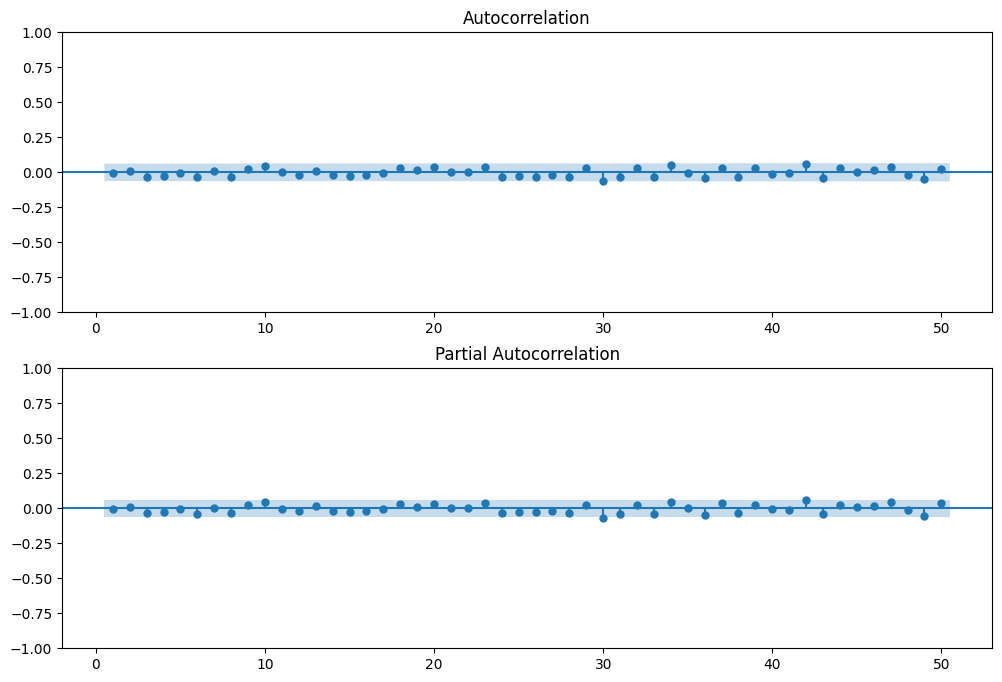

In [49]:
# ACF y PACF de la serie diferenciada por tendencia
print('ACF y PACF de la serie diferenciada sin tendencia')
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sgt.plot_acf(df_estacionariedad.d_1[1:],alpha = 0.05, zero =False, lags = 50, ax=ax[0])
sgt.plot_pacf(df_estacionariedad.d_1[1:], lags = 50, alpha = 0.05, method = ('ywm'), zero=False, ax=ax[1])
plt.show()

### Paso 5.1. Diferenciación Estacional para corregir las funciones ACF y PACF

In [50]:
#Para determinar los parametros del componente estacional, diferenciamos con el objetivo de eliminar la estacionalidad
seasonal_period = 21  # Periodicidad de 12 para datos mensuales con estacionalidad anual
data_seasonal_diff = df_estacionariedad[target_col].diff(seasonal_period).dropna()
data_seasonal_diff

Fecha
2021-04-30     4.653923
2021-05-03     5.652504
2021-05-04     2.754944
2021-05-05     0.294220
2021-05-06     1.381920
                ...    
2025-02-18    18.596634
2025-02-19    17.393608
2025-02-20    15.462280
2025-02-21    14.156937
2025-02-24    15.306633
Name: Adj Close, Length: 959, dtype: float64

``Graficamos para ver como ha cambiado la serie...``

In [51]:
# Crear subplots: 2 filas, 1 columna, compartir eje x
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.1,
                    subplot_titles=[f"Serie original ({target_col})", "Primera diferencia (serie estacionaria)"])

# Serie diferenciada original
fig.add_trace(
    go.Scatter(x=df_estacionariedad.index, y=df_estacionariedad.d_1,
               mode='lines', name='Serie Original', line=dict(color='blue')),
    row=1, col=1
)

# Serie diferenciada estacionalmente
fig.add_trace(
    go.Scatter(x=data_seasonal_diff.index, y=data_seasonal_diff,
               mode='lines', name='Primera Diferencia', line=dict(color='red')),
    row=2, col=1
)

# Línea horizontal en cero para la serie diferenciada
fig.add_trace(
    go.Scatter(x=data_seasonal_diff.index, y=[0]*len(data_seasonal_diff),
               mode='lines', name='Cero', line=dict(color='black', dash='dash')),
    row=2, col=1
)

# Layout interactivo
fig.update_layout(
    height=1000,
    # width=auto,
    title_text=f"Serie y Primera Diferencia Interactiva ({target_col})",
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

``Graficamos nuevamente las funciones ACF y PACF``

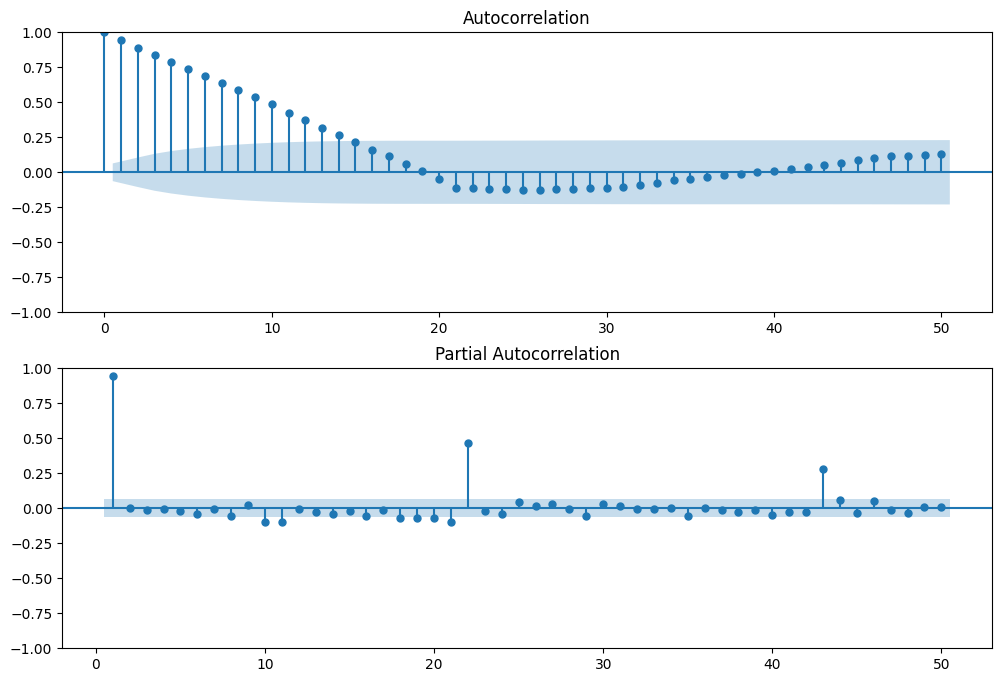

In [52]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sgt.plot_acf(data_seasonal_diff, lags=50, ax=ax[0])
sgt.plot_pacf(data_seasonal_diff, lags=50, ax=ax[1], zero=False)
plt.show()

> Se observa un posible patrón ``AR(1)`` con estacionalidad